In [1]:
from astropy.io import fits
from astropy.table import Table
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
with fits.open('NearbyClustersGaia_GALEX_SDSS_Skymapper_2MASS_WISE_ASASSN.fits') as hdu:
    asn_table = Table(hdu[1].data)
df = asn_table.to_pandas()
df_Coma = df[(df['Cluster']=='ComaBer ')]

In [3]:
df_Coma.dropna(subset = ['gmag','rpmag','bpmag'], inplace = True)
df_Coma.sort_values(by=['gmag'], inplace=True)

<ipython-input-3-1120e0fa2391>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Coma.dropna(subset = ['gmag','rpmag','bpmag'], inplace = True)
<ipython-input-3-1120e0fa2391>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Coma.sort_values(by=['gmag'], inplace=True)


In [106]:
x = np.array(df_Coma['gmag'])
y = np.array(df_Coma['bpmag']- df_Coma['rpmag'])
x_s1 = []
y_s1=[]
x_s2 = []
y_s2 = []
x_s3 = []
y_s3 = []
for i in range(len(x)):    
    if (6<=x[i]<=13):
        x_s1.append(x[i])
        y_s1.append(y[i])
    elif(13<x[i]):
        x_s2.append(x[i])
        y_s2.append(y[i])
    elif(x[i]<6):
        x_s3.append(x[i])
        y_s3.append(y[i])

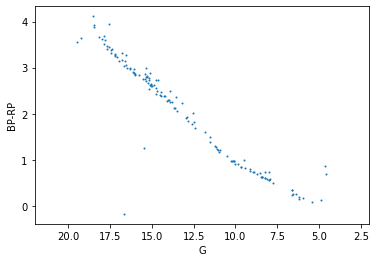

In [107]:
plt.scatter(x, y, s = 1)
plt.xlim(22,2)
plt.xlabel('G')
plt.ylabel('BP-RP')
plt.show()

In [108]:
# Extract the outliers
outliers_5sigma = [] #outliers outside of the 2 sigma value
y_5sigma = [] # corresponding bp-rp values
outliers_2sigma = [] #outliers outside of the 1.5 sigma value
y_2sigma = [] # corresponding bp-rp values

In [109]:
from scipy.interpolate import UnivariateSpline
def rejection(x_s1, y_s1, outliers_5sigma, y_5sigma, outliers_2sigma, y_2sigma):
    # get the difference between the values predicted by the model and the actual bp-rp values
    for j in range(20):
        diff = []
        model = UnivariateSpline(x_s1, y_s1, k=4)
        predicted = model(x_s1)
        #predicted = np.arange(len(x_s1), dtype=float)
        #for i in range(len(np.array(x_s1))):
         #   predicted[i] = predict(np.array(x_s1)[i])

        # get the difference between the values predicted by the model and the actual bp-rp values
        diff = y_s1 - predicted

        #get the standard deviation of the differences
        sigma = []
        precision = 10*(10**(-3))
        for n in range(len(x_s1)):
            if x_s1[n] <13:
                precision = 8*(10**(-3))
            elif x_s1[n] < 18:
                precision = 16*(10**(-3))
            else:
                precision = 200*(10**(-3))
            sigma.append(np.sqrt(2*precision**2))
        sigma = np.array(sigma)
        x_filtered = []
        y_filtered = []
        if j == 0:
            for k in range(len(diff)):
                if np.abs(diff[k]) >= 15*sigma[k]: #and 13<= x_s1[k]< 18:
                    outliers_5sigma.append(x_s1[k])
                    y_5sigma.append(y_s1[k])

                #elif diff[k] >= 2*sigma[k]:
                 #   outliers_2sigma.append(x_s1[k])
                  #  y_2sigma.append(y_s1[k])
                else:
                    x_filtered.append(x_s1[k])
                    y_filtered.append(y_s1[k])
            x_s1 = x_filtered
            y_s1 = y_filtered
        else:
            for k in range(len(diff)):
                if np.abs(diff[k]) >= 5*sigma[k]:
                    outliers_5sigma.append(x_s1[k])
                    y_5sigma.append(y_s1[k])

                #elif diff[k] >= 2*sigma[k]:
                 #   outliers_2sigma.append(x_s1[k])
                  #  y_2sigma.append(y_s1[k])
                else:
                    x_filtered.append(x_s1[k])
                    y_filtered.append(y_s1[k])
            x_s1 = x_filtered
            y_s1 = y_filtered
        
    return x_s1, y_s1,outliers_5sigma, y_5sigma, outliers_2sigma, y_2sigma, model



In [110]:
x_s1, y_s1, outliers_5sigma, y_5sigma, outliers_2sigma, y_2sigma, model = rejection(x_s1, y_s1, outliers_5sigma, y_5sigma, outliers_2sigma, y_2sigma)
x_s2, y_s2, outliers_5sigma, y_5sigma, outliers_2sigma, y_2sigma, model1 = rejection(x_s2, y_s2, outliers_5sigma, y_5sigma, outliers_2sigma, y_2sigma)




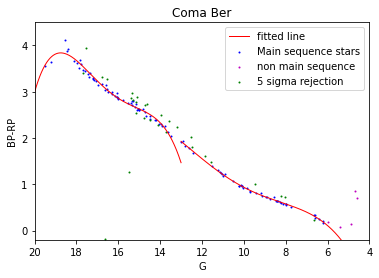

In [111]:
# plot the good values alongside the rejected values and the fitted line
plt.xlim(20,4)
plt.ylim(-0.2,4.5)
xs = np.linspace(4, 13, 2000)
xs1 = np.linspace(13,20,1000)
plt.plot(xs, model(xs), 'r', label = 'fitted line',lw=1)
plt.plot(xs1, model1(xs1), 'r', lw=1)
plt.scatter(x_s2, y_s2, c = 'b', label = 'Main sequence stars', s = 1)
plt.scatter(x_s1, y_s1, c = 'b', s = 1)
plt.scatter(x_s3, y_s3 , c = 'm', label = 'non main sequence', s = 1)
plt.scatter(outliers_5sigma, y_5sigma, c = 'g', label = '5 sigma rejection', s=1)
#plt.scatter(outliers_2sigma, y_2sigma, c = 'm',label = '2 sigma rejection', s=1)
plt.xlabel('G')
plt.ylabel('BP-RP')

#plt.plot(x_lin_reg1, y_lin_reg1, c = 'r', label='Fitted line1')
plt.title('Coma Ber')
plt.legend()
plt.show()

139